<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Image-Classification-Projects/blob/main/PyTorch-FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Import Libraries
import torch
from torch import nn
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Download FashionMNIST Dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

print("Total Classes: ", len(train_dataset.classes))

test_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

# Load Data
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size = 64, shuffle = False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 298kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.7MB/s]

Total Classes:  10


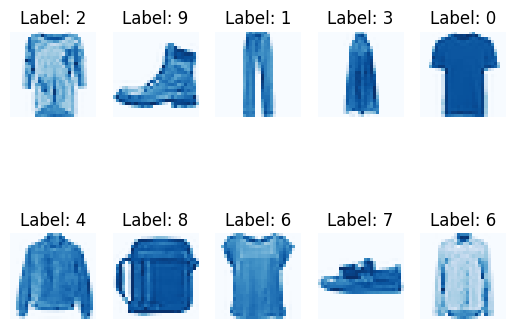

In [5]:
# Display Training Images
data_iter = iter(train_dl)
imgs, lbls = next(data_iter)

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(imgs[i].squeeze(), cmap = "Blues")
  plt.title(f'Label: {lbls[i].item()}')
  plt.axis('off')
plt.show()

In [7]:
# Define Convolutional Neural Network
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    self.c1 = nn.Conv2d(1, 31, kernel_size=3, padding=1, stride=3)
    self.relu1 = nn.ReLU()
    self.mp1 = nn.MaxPool2d(kernel_size=2),
    self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride = 2, padding=1)
    self.relu2 = nn.ReLU()
    self.mp2 = nn.MaxPool2d(kernel_size = 2)
    self.flat = nn.Flatten()
    self.cls = nn.Linear(64*7*7, num_classes)

  def forward(self, x):
    x = self.c1(x)
    x = self.relu1(x)
    x = self.mp1(x)
    x = self.c2(x)
    x = self.relu2(x)
    x = self.mp2(x)
    x = self.flat(x)
    x = self.cls(x)

    return x

In [8]:
# Set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Initialize Model
cnn = CNN(num_classes=10).to(device)

In [10]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)